In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns
from scipy.stats import zscore
import optuna
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

c:\Users\Administrator\Desktop\FinetuningOptuna\venv\lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


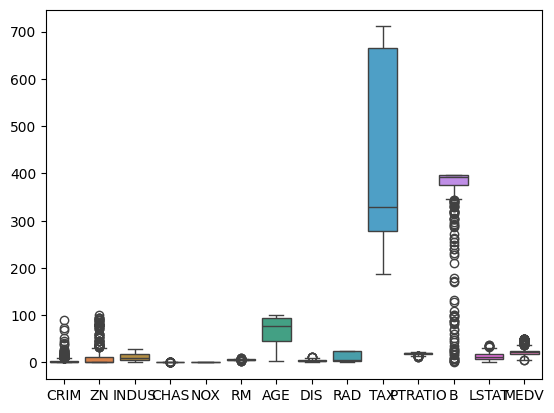

In [2]:
data = pd.read_csv("C:/Users/Administrator/Desktop/FinetuningOptuna/boston.csv")
sns.boxplot(data)
out = IForest(contamination=0.1)
out_pred = out.fit_predict(data)
std_data = data[out_pred == 1]

<Axes: >

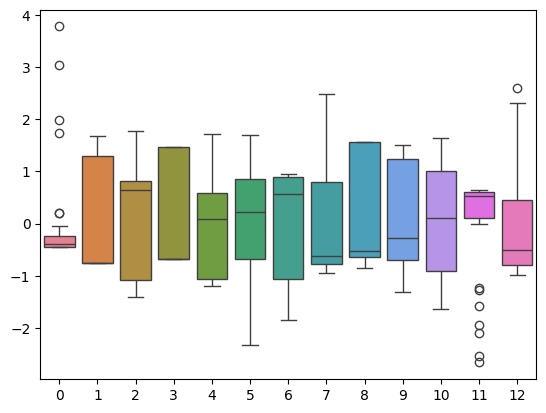

In [3]:
X = std_data.drop("MEDV", axis = 1)
y = std_data["MEDV"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sns.boxplot(X_train_scaled)


In [4]:
model = BaggingRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

,estimator,None
,n_estimators,10
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,None
,verbose,0


0.8201602435242089

4.868124999999999

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    bootstrap_features = trial.suggest_categorical('bootstrap_features', [False, True])
    warm_start = trial.suggest_categorical('warm_start', [False, True])
    max_samples = trial.suggest_float('max_samples', 0, 1)
    max_features = trial.suggest_float("max_features", 0, 1)
    oob_score_wanted = trial.suggest_categorical('oob_score', [True, False])
    oob_score = bool(oob_score_wanted and bootstrap)
    hiper = {
        'n_estimators': n_estimators,
        'max_samples': max_samples,
        'max_features': max_features,
        'bootstrap': bootstrap,
        'bootstrap_features': bootstrap_features,
        'oob_score': oob_score,
        'warm_start': warm_start,
        'n_jobs': -1,
        'random_state': 369,
        'verbose': 0,
    }
    try:
        model = BaggingRegressor(**hiper)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        return r2
    except Exception:
        return -1.0

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_jobs=-1, n_trials=1000)


[I 2025-08-24 19:50:56,412] A new study created in memory with name: no-name-3ef42e6c-63c1-4856-aa37-457b561212e2
[I 2025-08-24 19:50:56,446] Trial 13 finished with value: -1.0 and parameters: {'n_estimators': 96, 'bootstrap': True, 'bootstrap_features': True, 'warm_start': True, 'max_samples': 0.4658827291310087, 'max_features': 0.7321191407256926, 'oob_score': True}. Best is trial 13 with value: -1.0.
[I 2025-08-24 19:50:59,564] Trial 12 finished with value: 0.39205119472108796 and parameters: {'n_estimators': 88, 'bootstrap': False, 'bootstrap_features': False, 'warm_start': False, 'max_samples': 0.10114703173621675, 'max_features': 0.8285664672079774, 'oob_score': False}. Best is trial 12 with value: 0.39205119472108796.
[I 2025-08-24 19:50:59,571] Trial 17 finished with value: -1.0 and parameters: {'n_estimators': 31, 'bootstrap': True, 'bootstrap_features': True, 'warm_start': True, 'max_samples': 0.5026185004807675, 'max_features': 0.6848426359511899, 'oob_score': True}. Best is

,estimator,None
,n_estimators,71
,max_samples,0.9662946044569688
,max_features,0.6012946290702399
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,True
,n_jobs,None
,random_state,None
,verbose,0


0.9052028405623681

3.9553697183098575

<Axes: xlabel='MEDV'>

Text(0.5, 0, 'Y_true')

Text(0, 0.5, 'Y_pred')

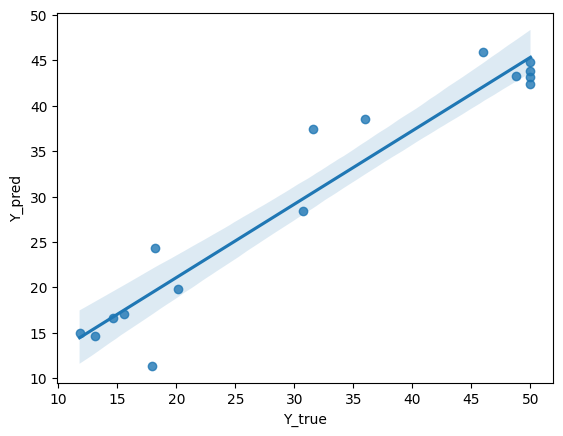

In [17]:
model = BaggingRegressor(**study.best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)
mean_absolute_error(y_test, y_pred)

sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Y_true")
plt.ylabel("Y_pred")